## Objective functions

Create a range of objective function to see how it impacts the ability of GP to learn and estimate uncertanity.

**Objective**: These reward function represent the objective of maintaining the flows below a threshold. 

### Hypothesis

1. A smoother reward function would be easier to learn. By that, using exponentials might ease the learning process. As gaussian processes are a bunch of exponentials.
2. Same things as the RL, have to really carefull on how these functions are defined.
3. How does uncertanity variance matter? For instance, it might not always grow with data, there could be swaths of actions that do not have uncertanity. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

## Linear Objective Function

In [2]:
def obj_lin(flow, depth, overflows, threshold=0.50):
    flows = pd.Series(flow)
    depth = pd.Series(depth)
    # total outflows from basin
    sum_flows = flows.sum()
    # flows below threshold
    flows[flows > threshold] = 0.0
    sum_flows_threshold = flows.sum()
    # ratio of flows below threshold 
    ratio = sum_flows_threshold/(sum_flows + 10**(-5)) # Pad the denominator to aviod error
    # To have the minimum at 0.0
    return 1.0 - ratio

## Exponential Objective Function

In [3]:
def obj_exp(flow, depth, overflows, threshold=0.50):
    flows = pd.Series(flow)
    depth = pd.Series(depth)
    # total outflows from basin
    sum_flows = flows.sum()
    # flows below threshold
    flows[flows > threshold] = 0.0
    sum_flows_threshold = flows.sum()
    # ratio of flows below threshold 
    ratio = sum_flows_threshold/(sum_flows + 10**(-5))# Pad the denominator to aviod error
    return 2.0-np.exp(ratio)

### Test the objective functions

In [4]:
data = np.load("./Responses.npy").item()

In [5]:
data['00'].keys()

dict_keys(['flows', 'overflow', 'depth'])

### Translate data to loss 

In [6]:
def unravel_storms(action_idx, storm, data, objective_function, threshold=0.5):
    key_event = str(action_idx) + str(storm)
    reward = objective_function(data[key_event]["flows"], data[key_event]["depth"], data[key_event]["overflow"], threshold)
    return reward

## Plot the objective functions

In [12]:
reward_lin = np.zeros((10, 100))
reward_exp = np.zeros((10, 100))
for action in range(0, 100):
    for rainevent in range(0, 10):
        reward_lin[rainevent, action] = unravel_storms(action, rainevent, data, obj_lin, 0.6)
        reward_exp[rainevent, action] = unravel_storms(action, rainevent, data, obj_exp, 0.6)

Text(0.5, 1.0, 'exp')

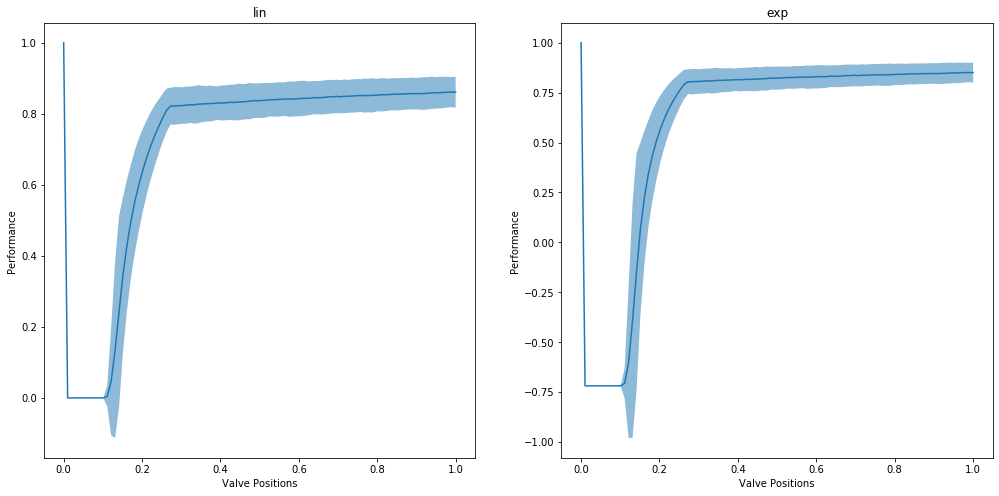

In [14]:
actions = np.linspace(0.0, 1.0, 100)
plt.figure(figsize=(17,8))
plt.subplot(1, 2, 1)
m = reward_lin.mean(axis=0)
std = np.std(reward_lin, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std

plt.plot(actions, reward_lin.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)
plt.xlabel("Valve Positions")
plt.ylabel("Performance")
plt.title("lin")

plt.subplot(1, 2, 2)
m = reward_exp.mean(axis=0)
std = np.std(reward_exp, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward_exp.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)
plt.xlabel("Valve Positions")
plt.ylabel("Performance")
plt.title("exp")

Need something that is smoother...

In [26]:
# Generate random samples
reward = []
action = []
acts = np.linspace(0.0, 1.0, 100)
for i in range(0, 300):
    a = np.random.choice(np.linspace(0, 99, 100, dtype=int))
    action.append(acts[a])
    rainevent = np.random.choice(np.linspace(0, 9, 10, dtype=int))
    reward.append(unravel_storms(a, rainevent, data, obj_lin, 0.6))

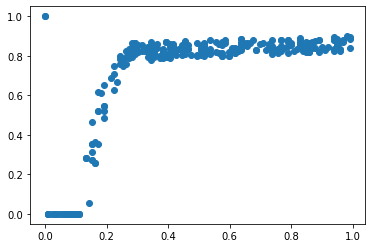

In [27]:
plt.plot(action, reward, 'o')

## Save this data for GP

In [29]:
data_sample = {"reward":reward, "actions":action}

In [31]:
np.save("DataSamples", data_sample)